In [2]:
'''
Load csv files and build dictionaries
'''
import collections
import csv
import os

try:
    from src.maps import csv as csvFolder  #note: MMWPF path must be added to enviornmental variables PYTHONPATH (see setup.py)
    csv_path = csvFolder.path()
except:
    csv_path = os.path.join("./", "csv_maps/")
    
print(csv_path)
fileName = 'stations_all_clean.csv'
##### build ptDict with unfilled lineRef #####
with open(csv_path+fileName, 'r') as csvfile:
    tmp = csv.reader(csvfile)
    header = next(tmp, None)
    dictReader = csv.DictReader(csvfile, fieldnames=header) #get public transit data
    ptDict = collections.OrderedDict() # create public transit dictionary
    for row in dictReader:
        ptDict[row['stopId']] = row #set dictionary key equal to stopId
        ptDict[row['stopId']]['lineRef'] = collections.OrderedDict() #create lineRef dictionary
  

fileName = 'lines_all_clean.csv'
lineIdDict = collections.OrderedDict() # create lineId dictionary for public transit

##### continue building ptDict by filling in lineRef data + build lineIdDict #####
with open(csv_path+fileName, 'r') as csvfile:
    tmp = csv.reader(csvfile)
    header = next(tmp, None)
    dictReader = csv.DictReader(csvfile, fieldnames=header) #get public transit data
    for row in dictReader:
        try:
            ptDict[row['stopId']]['lineRef'][row['lineRef']] = row
            
            if row['lineId'] not in lineIdDict.keys():
                lineIdDict[row['lineId']] = collections.OrderedDict()
                lineIdDict[row['lineId']][row['lineRef']] = collections.OrderedDict()
                lineIdDict[row['lineId']][row['lineRef']][row['sequence']] = row
            elif row['lineRef'] not in lineIdDict[row['lineId']].keys(): #if lineRef not currently in dict
                lineIdDict[row['lineId']][row['lineRef']] = collections.OrderedDict()
                lineIdDict[row['lineId']][row['lineRef']][row['sequence']] = row
            else: #lineRef is in dictionary, just update seq
                lineIdDict[row['lineId']][row['lineRef']][row['sequence']] = row
        except Exception:
            print(row)
            
       

C:\Users\BladeRunner\Desktop_Virtual\BladeRunnerGIT\MMWPF\src\maps\csv\


In [4]:
'''
Check ptDict dictionary and modify ptDict flags to be consistant with lineIdDict
'''

from IPython.display import clear_output

busErrorT = 0
busErrorF = 0
tramErrorT = 0
tramErrorF = 0
subwayErrorT = 0
subwayErrorF = 0
bustramErrorT = 0

for lineId in lineIdDict:
    for lineRef in lineIdDict[lineId]:
        for seq in lineIdDict[lineId][lineRef]:
            stopId = lineIdDict[lineId][lineRef][seq]['stopId']
            bus = ptDict[stopId]['bus']
            tram = ptDict[stopId]['tram']
            subway = ptDict[stopId]['subway']
            if bus == 'true' and lineIdDict[lineId][lineRef][seq]['bus'] == 'false':
                busErrorT = busErrorT+1 #note: in ptDict bus & tram stopsids can both be true, so error increment expected here
            elif bus == 'false' and lineIdDict[lineId][lineRef][seq]['bus'] == 'true': 
                busErrorF = busErrorF+1
                ptDict[stopId]['bus'] = 'true' #force bus flag to true since this stopid is also a bus stop
            if tram == 'true' and lineIdDict[lineId][lineRef][seq]['tram'] == 'false':
                tramErrorT = tramErrorT+1  #note: in ptDict bus & tram stopsids can both be true, so error increment expected here
            elif tram == 'false' and lineIdDict[lineId][lineRef][seq]['tram'] == 'true': 
                tramErrorF = tramErrorF+1
                ptDict[stopId]['tram'] = 'true' #force tram flag to true since this stopid is also a tram stop
            if subway == 'true' and lineIdDict[lineId][lineRef][seq]['subway'] == 'false':
                subwayErrorT = subwayErrorT+1
            elif subway == 'false' and lineIdDict[lineId][lineRef][seq]['subway'] == 'true': 
                subwayErrorF = subwayErrorF+1
                ptDict[stopId]['subway'] = 'true' #force subway flag to true since this stopid is also a subway stop
            if tram == 'true' and bus == 'true':
                bustramErrorT = bustramErrorT+1

    clear_output(wait=True)
    print('busErrorT: %d\t tramErrorT: %d\t subwayErrorT: %d\nbusErrorF: %d\t tramErrorF: %d   \t subwayErrorF: %d\nbustramErrorT: %d'%(busErrorT, tramErrorT, subwayErrorT, busErrorF, tramErrorF, subwayErrorF, bustramErrorT))    
    
    

busErrorT: 35	 tramErrorT: 486	 subwayErrorT: 0
busErrorF: 0	 tramErrorF: 0   	 subwayErrorF: 0
bustramErrorT: 521


In [ ]:
##### test lineIdDict #####
lineId = '3642664'
print(len(lineIdDict.keys()))
for lineRef in lineIdDict[lineId]:
    for seq in lineIdDict[lineId][lineRef]:
        try:
            lat1 = float(ptDict[lineIdDict[lineId][lineRef][seq]['stopId']]['lat'])
            lon1 = float(ptDict[lineIdDict[lineId][lineRef][seq]['stopId']]['lon'])
            seq2 = str(int(seq) + 1)
            if seq2 in lineIdDict[lineId][lineRef].keys():
                lat2 = float(ptDict[lineIdDict[lineId][lineRef][seq2]['stopId']]['lat'])
                lon2 = float(ptDict[lineIdDict[lineId][lineRef][seq2]['stopId']]['lon'])
                dis = ox.distance.great_circle_vec(lat1, lon1, lat2, lon2)
                print('lineId: %s\t lineRef: %s\t seq:  %s  dist(%s->%s): %.2f\t stopId: %s\t stopName: %s' 
                                                                            %(lineId, lineRef, seq, seq, seq2, dis, 
                                                                            lineIdDict[lineId][lineRef][seq]['stopId'], 
                                                                            lineIdDict[lineId][lineRef][seq]['stopName']))
        except Exception:
            pass
        
#print(lineIdDict[lineId][lineRef]['0'])

In [6]:
#Info only: check how many stops have line references
n=0
nn=0
nnn=0

for stopId in ptDict:
    if len(ptDict[stopId]['lineRef'].keys()) > 0:
        n = n+1
        nn = nn + len(ptDict[stopId]['lineRef'].keys())
    else:
        nnn = nnn+1
        
print('number of stops with lineReferences: %d' % n)
print('total number of lineReferences: %d' % nn)
print('number of stops without lineReferences: %d' % nnn)

number of stops with lineReferences: 9728
total number of lineReferences: 17952
number of stops without lineReferences: 6386


In [8]:
'''
load G_walk & G_drive networks (both will be used to help generate the bus & tram graphs)
'''
import osmnx as ox
try:
    from src.maps import graphML
    graph_path = graphML.path()
except:
    graph_path = os.path.join("./", "comp_graph/")
    
G_walk = ox.load_graphml(graph_path + 'G_walk.graphml')
G_drive = ox.load_graphml(graph_path + 'G_drive.graphml')

In [28]:
'''
load walk nodes and edges
'''
gdf_nodes_walk, gdf_edges_walk = ox.graph_to_gdfs(G_walk)

In [8]:
'''
Filter public transit network to only include the city of munich
'''
lonMax = max(gdf_nodes_walk.x.values) #get furthest east walk node
lonMin = min(gdf_nodes_walk.x.values) #get furthest west walk node
latMax = max(gdf_nodes_walk.y.values) #get furthest north walk node
latMin = min(gdf_nodes_walk.y.values) #get furthest south walk node

print('north: %.3f\t south: %.3f\t west: %.3f\t east: %.3f\t'%(latMax, latMin, lonMin, lonMax))

print('number of stopIDs before filter: %d'% len(ptDict))
for stopId in list(ptDict.keys()): #need to explicitly callout list() as ptDict is mutated during for loop
    lat = float(ptDict[stopId]['lat'])
    lon = float(ptDict[stopId]['lon'])
    if lat > latMax or lat < latMin:
        del ptDict[stopId]  #delete stopId from ptDict (outside of city boundaries)
        continue
    if lon > lonMax or lon < lonMin:
        del ptDict[stopId]  #delete stopId from ptDict (outside of city boundaries)
        continue
print('number of stopIDs after filter: %d'% len(ptDict))


north: 48.247	 south: 48.062	 west: 11.361	 east: 11.715	
number of stopIDs before filter: 16114
number of stopIDs after filter: 6116


In [12]:
#testing only: 
import math

def dotproduct(v1, v2):
  return sum((a*b) for a, b in zip(v1, v2))

def length(v):
  return math.sqrt(dotproduct(v, v))

def angle(v1, v2):
  return math.degrees(math.acos(dotproduct(v1, v2) / (length(v1) * length(v2))))

stopId1 = '2782065354'
stopId2 = '2779899384'
print(ptDict[stopId1])
nodeId_walk, dist_to_walk = ox.get_nearest_node(G_walk, 
                                                       (float(ptDict[stopId1]['lat']), 
                                                        float(ptDict[stopId1]['lon'])), 
                                                        method='haversine', return_dist=True)
print(nodeId_walk)
print(dist_to_walk)
print(nodeId_drive)
print(dist_to_drive)

edgeTuple = ox.get_nearest_edge(G_drive, 
                               (float(ptDict[stopId1]['lat']), 
                                float(ptDict[stopId1]['lon'])), 
                                return_dist=True)
nodeId_drive_u = edgeTuple[0]
nodeId_drive_v = edgeTuple[1]


dist_to_drive_u = ox.distance.great_circle_vec(G_walk.nodes[nodeId_walk]['y'],
                                               G_walk.nodes[nodeId_walk]['x'],
                                               G_drive.nodes[nodeId_drive_u]['y'],
                                               G_drive.nodes[nodeId_drive_u]['x'])
dist_to_drive_v = ox.distance.great_circle_vec(G_walk.nodes[nodeId_walk]['y'],
                                               G_walk.nodes[nodeId_walk]['x'],
                                               G_drive.nodes[nodeId_drive_v]['y'],
                                               G_drive.nodes[nodeId_drive_v]['x'])

# print(edgeTuple) #(u, v, key, dist)
v1 = ((G_drive.nodes[nodeId_drive_u]['x'] - G_drive.nodes[nodeId_drive_v]['x']), 
      (G_drive.nodes[nodeId_drive_u]['y'] - G_drive.nodes[nodeId_drive_v]['y']))
v2 = ((float(ptDict[stopId1]['lon']) - float(ptDict[stopId2]['lon'])), 
      (float(ptDict[stopId1]['lat']) - float(ptDict[stopId2]['lat'])))
print(v1)
print(v2)
print(angle(v1,v2))
#print(G_driveTmp.nodes[nodeId_walk].keys())
#print(G_driveTmp.edges._adjdict[nodeId_walk])

{'stopId': '2782065354', 'stopName': 'Marchioninistrasse', 'lat': '48.1136504', 'lon': '11.4769167', 'bus': 'true', 'tram': 'false', 'subway': 'false', 'stopPositionFlag': 'true', 'x': '4461157.5', 'y': '5330754.5', 'lineRef': OrderedDict([('56', {'lineId': '3642664', 'lineRef': '56', 'from': 'Fï¿½rstenried West', 'to': 'Schloss Blutenburg', 'bus': 'true', 'tram': 'false', 'subway': 'false', 'sequence': '6', 'stopId': '2782065354', 'stopName': 'Marchioninistrasse'}), ('N40', {'lineId': '916476', 'lineRef': 'N40', 'from': 'Klinikum Gro?hadern', 'to': 'Kieferngarten', 'bus': 'true', 'tram': 'false', 'subway': 'false', 'sequence': '3', 'stopId': '2782065354', 'stopName': 'Marchioninistrasse'})])}


KeyError: 'lat'

In [15]:
"""
Add Bus Nodes & Edges
1. Process evaluates stopID lat/lon and finds closest walk node from G_walk
2. Next, stopID lat/lon are compared with G_drive|G_tmp to find closest edge
    2.1 Edge orientation is determined and compared to orientation of bus route edge (seqx->seqx+1)
    2.2 If orientation difference is < 100 degrees, use edge nodes (u,v) see 3.
    2.2 If orientation difference is > 100 degrees, delete edge from G_tmp and repeat 2.
3. Bi-directionally connect found edge nodes(u,v) to found walk node and insert into G_driveTmp 
   with stopid as a new node attribute
""" 
from IPython.display import clear_output
import networkx as nx
import collections
import copy
import math
import time

def OptimizedGraph(lat, lon, tileSize=0.002, graphType='walk'):
    #note: tileSize=0.001 corresponds to 111.12 meters
    G_tmp = nx.MultiDiGraph()
    latMax = lat + tileSize
    latMin = lat - tileSize
    lonMax = lon + tileSize
    lonMin = lon - tileSize
    retry = True
    
    if graphType == 'walk':
        latIdList = [nodeId for nodeId in G_walk_nodIdLatDict 
                     if G_walk_nodIdLatDict[nodeId] > latMin and G_walk_nodIdLatDict[nodeId] < latMax]
        lonIdList = [nodeId for nodeId in G_walk_nodIdLonDict 
                     if G_walk_nodIdLonDict[nodeId] > lonMin and G_walk_nodIdLonDict[nodeId] < lonMax]

        if len(lonIdList) < len(latIdList):
            nodeList_wAttr = [(nodeId, {'y': G_walk_nodIdLatDict[nodeId], 'x': G_walk_nodIdLonDict[nodeId]}) 
                              for nodeId in lonIdList if nodeId in latIdList]
        else:
            nodeList_wAttr = [(nodeId, {'y': G_walk_nodIdLatDict[nodeId], 'x': G_walk_nodIdLonDict[nodeId]})
                         for nodeId in latIdList if nodeId in lonIdList]

        if nodeList_wAttr:  #if nodeList_wAttr is not empty
            G_tmp.add_nodes_from(nodeList_wAttr)
        else:
            G_tmp.add_node(1, y=0.00, x=0.00) #add dummy node
    
    while(retry):
        retry = False
        if graphType == 'drive':
            latIdList = [nodeId for nodeId in G_drive_nodIdLatDict 
                         if G_drive_nodIdLatDict[nodeId] > latMin and G_drive_nodIdLatDict[nodeId] < latMax]
            lonIdList = [nodeId for nodeId in G_drive_nodIdLonDict 
                         if G_drive_nodIdLonDict[nodeId] > lonMin and G_drive_nodIdLonDict[nodeId] < lonMax]

            if len(lonIdList) < len(latIdList):
                nodeList_wAttr = [(nodeId, {'y': G_drive_nodIdLatDict[nodeId], 'x': G_drive_nodIdLonDict[nodeId]}) 
                                  for nodeId in lonIdList if nodeId in latIdList]
            else:
                nodeList_wAttr = [(nodeId, {'y': G_drive_nodIdLatDict[nodeId], 'x': G_drive_nodIdLonDict[nodeId]})
                             for nodeId in latIdList if nodeId in lonIdList]
            if nodeList_wAttr:  #if nodeList_wAttr is not empty
                G_tmp.add_nodes_from(nodeList_wAttr)
            else:
                G_tmp.add_node(1, y=0.00, x=0.00) #add dummy node

            try:
                nodeList = list(zip(*nodeList_wAttr))[0]
                edgeList_wAttr = []
                for i in range(0, len(nodeList_wAttr)):
                    for v in G_drive.edges._adjdict[nodeList_wAttr[i][0]]:
                        if v not in nodeList:
                            G_tmp.add_node(v, y=G_drive.nodes[v]['y'], x=G_drive.nodes[v]['x'])
                        edgeList_wAttr.append((nodeList_wAttr[i][0], v, G_drive.edges._adjdict[nodeList_wAttr[i][0]][v][0]))
                if len(edgeList_wAttr) < 6:
                    if logging:
                        print('Exception!: Too few edges in tile')
                        print('increasing tile size...')
                    latMax = latMax + tileSize
                    latMin = latMin - tileSize
                    lonMax = lonMax + tileSize
                    lonMin = lonMin - tileSize
                    retry = True
                else:
                    G_tmp.add_edges_from(edgeList_wAttr)  
            except Exception as e:
                if logging:
                    print('Exception!: %s' % e)
                    print('increasing tile size...')
                latMax = latMax + tileSize
                latMin = latMin - tileSize
                lonMax = lonMax + tileSize
                lonMin = lonMin - tileSize
                retry = True
            
        G_tmp.graph['crs'] = G_drive.graph['crs']  #copy from G_drive
        G_tmp.graph['created_with'] = G_drive.graph['created_with'] #copy from G_drive
        G_tmp.graph['simplified'] = G_drive.graph['simplified']
    return G_tmp

def AddWalkNodeToDriveGraph(stopId, nodeId_walk, nodeId_drive_u, nodeId_drive_v, dist_to_drive_u, dist_to_drive_v):
    ### Handle nodeId_drive_u ###
    #if node id's are not equal, temporarily add walk node to drive graph
    if nodeId_walk != nodeId_drive_u: 
        # add node if not existing in G_driveTmp already
        if nodeId_walk not in G_driveTmp.nodes.keys():
            G_driveTmp.add_node(nodeId_walk, 
                                y=G_walk.nodes[nodeId_walk]['y'], 
                                x=G_walk.nodes[nodeId_walk]['x'], 
                                osmid=G_walk.nodes[nodeId_walk]['osmid'],
                                stopid=list())
            #append stopid to node attribute (this is a list because the same node can have multiple stopids)
            if 'stopid' not in G_driveTmp.nodes[nodeId_walk].keys():
                G_driveTmp.nodes[nodeId_walk]['stopid'] = list()
            G_driveTmp.nodes[nodeId_walk]['stopid'].append(stopId)
            
            G_driveTmp.add_edge(nodeId_walk, nodeId_drive_u, length=dist_to_drive_u)
            G_driveTmp.add_edge(nodeId_drive_u, nodeId_walk, length=dist_to_drive_u)
        else: #G_driveTmp already contains the walk node id, just append a stop id    
            if 'stopid' not in G_driveTmp.nodes[nodeId_walk].keys():
                G_driveTmp.nodes[nodeId_walk]['stopid'] = list()
            G_driveTmp.nodes[nodeId_walk]['stopid'].append(stopId)
           
    ### Handle nodeId_drive_v ###
    #if node id's are not equal, temporarily add walk node to drive graph
    if nodeId_walk != nodeId_drive_v: 
        # add node if not existing in G_driveTmp already
        if nodeId_walk not in G_driveTmp.nodes.keys():
            G_driveTmp.add_node(nodeId_walk, 
                                y=G_walk.nodes[nodeId_walk]['y'], 
                                x=G_walk.nodes[nodeId_walk]['x'], 
                                osmid=G_walk.nodes[nodeId_walk]['osmid'],
                                stopid=list())
        #append stopid to node attribute (this is a list because the same node can have multiple stopids)
        if 'stopid' not in G_driveTmp.nodes[nodeId_walk].keys():
            G_driveTmp.nodes[nodeId_walk]['stopid'] = list()
        G_driveTmp.nodes[nodeId_walk]['stopid'].append(stopId)

        G_driveTmp.add_edge(nodeId_walk, nodeId_drive_v, length=dist_to_drive_v)
        G_driveTmp.add_edge(nodeId_drive_v, nodeId_walk, length=dist_to_drive_v)
    else: #G_driveTmp already contains the walk node id, just append a stop id
        if 'stopid' not in G_driveTmp.nodes[nodeId_walk].keys():
            G_driveTmp.nodes[nodeId_walk]['stopid'] = list()
        G_driveTmp.nodes[nodeId_walk]['stopid'].append(stopId)
    
G_walk_nodIdLatDict = nx.get_node_attributes(G_walk, "y")
G_walk_nodIdLonDict = nx.get_node_attributes(G_walk, "x")
G_drive_nodIdLatDict = nx.get_node_attributes(G_drive, "y")
G_drive_nodIdLonDict = nx.get_node_attributes(G_drive, "x")

G_driveTmp = copy.deepcopy(G_drive)

logging = False
#build Bus graph network
total = len(ptDict)
for stopId in ptDict:
    total = total-1
    if ptDict[stopId]['bus'] == 'true':        
        #get closest walk node id & distance to current stop id
            
        nodeId_walk, dist_to_walk = ox.get_nearest_node(OptimizedGraph(float(ptDict[stopId]['y']), 
                                                                       float(ptDict[stopId]['x']),
                                                                       tileSize=0.002, graphType='walk'), 
                                                                       (float(ptDict[stopId]['lat']), 
                                                                        float(ptDict[stopId]['lon'])), 
                                                                        method='haversine', return_dist=True)
        
        #print(dist_to_walk)
        #if stopId is farther than 200m from a walking node, then ignore
        if dist_to_walk > 200.0: 
            ptDict[stopId]['insideCity'] = False
            continue
        else:
            ptDict[stopId]['insideCity'] = True
        
        #get closest drive edge to actual bus stop lat/lon, returns 2 driveNode ids that are to be connected to nodeId_walk
        #try finding closest edge, comparing vector angle to route direction (seq1->seq2). 
        #If angle > 100degrees, find next closest edge by deleting the found edge and running ox.get_nearest_edge again
        
        G_tmp = OptimizedGraph(float(ptDict[stopId]['lat']), 
                               float(ptDict[stopId]['lon']), 
                               tileSize=0.02, graphType='drive')
        nn=0
        findEdge=True
        findEdgeCounter = 0
        lineRefEdgeTracker = collections.OrderedDict()
        
        while(findEdge):
            if not ptDict[stopId]['lineRef']:
                findEdge = False
                break
            else:
                if logging:
                    print(ptDict[stopId]['lineRef'].keys())
                
            #t1 = time.time() 
            try:
                edgeTuple = ox.get_nearest_edge(G_tmp, 
                                               (float(ptDict[stopId]['lat']), 
                                                float(ptDict[stopId]['lon'])), 
                                                return_dist=True)
            except Exception as e:
                if logging:
                    print('Exception!: %s' % e)
                findEdge = False
                break
                
            #t2 = time.time()
            #print('time: %.6f' % (t1-t2))

            nodeId_drive_u = edgeTuple[0]
            nodeId_drive_v = edgeTuple[1]

            dist_to_drive_u = ox.distance.great_circle_vec(G_walk.nodes[nodeId_walk]['y'],
                                                           G_walk.nodes[nodeId_walk]['x'],
                                                           G_drive.nodes[nodeId_drive_u]['y'],
                                                           G_drive.nodes[nodeId_drive_u]['x'])
            dist_to_drive_v = ox.distance.great_circle_vec(G_walk.nodes[nodeId_walk]['y'],
                                                           G_walk.nodes[nodeId_walk]['x'],
                                                           G_drive.nodes[nodeId_drive_v]['y'],
                                                           G_drive.nodes[nodeId_drive_v]['x'])

            if logging:
                print('dist to u: %.3f'% dist_to_drive_u)
                print('dist to v: %.3f'% dist_to_drive_v)
            #get bearing angle of nearest road edge
            v1 = ox.bearing.get_bearing((G_drive.nodes[nodeId_drive_u]['y'], G_drive.nodes[nodeId_drive_u]['x']),
                                        (G_drive.nodes[nodeId_drive_v]['y'], G_drive.nodes[nodeId_drive_v]['x']))

            
            for lineRef in ptDict[stopId]['lineRef']: #could be multiple routes using same stopid
                lineId = ptDict[stopId]['lineRef'][lineRef]['lineId']
                seq1 = ptDict[stopId]['lineRef'][lineRef]['sequence']
                seq2 = str(int(seq1) + 1)
                try:
                    stopId2 = lineIdDict[lineId][lineRef][seq2]['stopId']
                    ptDict[stopId2] #test if stopId2 exists
                except Exception: #no 2nd seq available, use first edge found by ox.get_nearest_edge
                    stopId2 = 'unknown'
                    try:
                        if lineRefEdgeTracker[lineRef] == True: #if edge found already, skip add node/edge function
                            continue
                    except Exception:
                        findEdgeCounter = findEdgeCounter + 1
                        lineRefEdgeTracker[lineRef] = True
                        AddWalkNodeToDriveGraph(stopId, nodeId_walk, 
                                                nodeId_drive_u, nodeId_drive_v, 
                                                dist_to_drive_u, dist_to_drive_v)
                        if logging:
                            print('lineId: %s\t lineRef: %s\t seq(%s->%s)\t stopId2: %s\t angle: unknown\n' 
                                  %(lineId, lineRef, seq1, seq2, stopId2))
                        continue

                # get bearing angle of of edge: seqx -> seqx+1
                v2 = ox.bearing.get_bearing((float(ptDict[stopId]['lat']), float(ptDict[stopId]['lon'])),
                                            (float(ptDict[stopId2]['lat']), float(ptDict[stopId2]['lon'])))
                
                #find difference between nearest road edge and sequence edge
                vAngle = abs(v1-v2)
                if vAngle >= 180.0:
                    vAngle = 180.0 - (vAngle-180.0)

                if vAngle < 100:  #if road and sequence edge are < 100 degree different orientation 
                    try:
                        if lineRefEdgeTracker[lineRef] == True: #if edge found already, skip add node/edge function
                            continue
                    except Exception:
                        findEdgeCounter = findEdgeCounter + 1
                        lineRefEdgeTracker[lineRef] = True
                        AddWalkNodeToDriveGraph(stopId, nodeId_walk, 
                                                nodeId_drive_u, nodeId_drive_v, 
                                                dist_to_drive_u, dist_to_drive_v)
                        if logging:
                            print('lineId: %s\t lineRef: %s\t seq(%s->%s)\t stopId2: %s\t angle: %.2f\n' 
                                  %(lineId, lineRef, seq1, seq2, stopId2, vAngle))
                else:
                    # remove edge so that next time ox.get_nearest_edge is run, a different edge is found
                    try:
                        G_tmp.remove_edge(nodeId_drive_u, nodeId_drive_v)
                        if logging:
                            print('angle is: %.2f  edge removed' % vAngle)
                    except Exception as e:
                        if logging:
                            print('Exception!: %s The edge was already removed' % e)
                           
            if findEdgeCounter == len(ptDict[stopId]['lineRef'].keys()):
                findEdge = False
                
    if logging == False:       
        clear_output(wait=True)
        print('remaining stopIds: %d' %(total))

In [11]:
"""
Add Tram, U-bahn, S-bahn Nodes
1. Process evaluates stopID lat/lon and finds closest walk node
2. closest walk node is inserted into G_driveTmp with stopid as a new node attribute
""" 

#build rail graph network
total = len(ptDict)
for stopId in ptDict:
    total = total-1
    if(ptDict[stopId]['tram'] == 'true' or ptDict[stopId]['subway'] == 'true' or
      (ptDict[stopId]['bus'] == 'false' and ptDict[stopId]['tram'] == 'false' and ptDict[stopId]['subway'] == 'false')):        
        #get closest walk node id & distance to current stop id
        nodeId_walk, dist_to_walk = ox.get_nearest_node(G_walk, 
                                                       (float(ptDict[stopId]['lat']), 
                                                        float(ptDict[stopId]['lon'])), 
                                                        method='haversine', return_dist=True)
        #if stopId is farther than 200m from a walking node, then ignore
        if dist_to_walk > 200.0: 
            ptDict[stopId]['insideCity'] = False
            continue
        else:
            ptDict[stopId]['insideCity'] = True
        
    
        ### Handle nodeId_walk ###
        #temporarily add walk node to drive graph

        # add node if not existing in G_driveTmp already
        if nodeId_walk not in G_driveTmp.nodes.keys():
            G_driveTmp.add_node(nodeId_walk, 
                                y=G_walk.nodes[nodeId_walk]['y'], 
                                x=G_walk.nodes[nodeId_walk]['x'], 
                                osmid=G_walk.nodes[nodeId_walk]['osmid'],
                                stopid=list())
        #append stopid to node attribute (this is a list because the same node can have multiple stopids)
        if 'stopid' not in G_driveTmp.nodes[nodeId_walk].keys():
            G_driveTmp.nodes[nodeId_walk]['stopid'] = list()
        G_driveTmp.nodes[nodeId_walk]['stopid'].append(stopId)
            
        clear_output(wait=True)
        print('remaining stopIds: %d' %(total))


remaining stopIds: 12


# Checkpoint Save

In [22]:
#save
import json

with open(graph_path + 'ptDict.json', 'w') as fp:
    json.dump(ptDict, fp, sort_keys=False, indent=4)
with open(graph_path + 'lineIdDict.json', 'w') as fp:
    json.dump(lineIdDict, fp, sort_keys=False, indent=4)
    
ox.save_graphml(G_driveTmp, filepath=graph_path + 'G_driveTmp.graphml')


In [29]:
#load
import networkx as nx
import osmnx as ox
import json
import collections

with open(graph_path + 'ptDict.json', 'r') as fp:
    ptDict = json.load(fp, object_pairs_hook=collections.OrderedDict)
    
with open(graph_path + 'lineIdDict.json', 'r') as fp:
    lineIdDict = json.load(fp, object_pairs_hook=collections.OrderedDict)
    
G_driveTmp = ox.load_graphml(graph_path + 'G_driveTmp.graphml')

In [24]:
#testing only
import networkx as nx
#fig, ax = ox.plot_graph(G_driveTmp)
nodeIdDict = nx.get_node_attributes(G_driveTmp, "y")
# list out keys and values separately
key_list = list(nodeIdDict.keys())
val_list = list(nodeIdDict.values())
stopId = '379853858'
#print(nodeIdDict)
#val_list[3].index('379853858')

#print(key_list)
#nodeIndex = [val_list.index(stopIdList) for stopIdList in val_list if stopId in stopIdList][0]
#print(key_list[nodeIndex])
newOsmid = 80798096

### Generate G_Public with Realistic Bus Network

In [ ]:
'''
1. Process iterates through each bus line sequence by sequence and uses ox.shortest_path(G_driveTmp, nodeId_u, nodeId_v)
   to return a list of nodes from the drive network that connects 2 bus stops along a bus route.
2. The list of nodes is added to G_public and edges are created and populated with attribute data from G_driveTmp as well
   as from ptDict
'''
def GetNodeAttributes(u1, i, lastIndex):
    attrDict = G_driveTmp.nodes[u1]
    if i == 0 or i == lastIndex:
        attrDict['color'] = 'r' #set stopid nodes as red color
    return attrDict

def GetEdgeAttributes(u1, v1, u2, v2, osmid, lineId, lineRef, seq1, seq2):
    # get new edge street name
    try: #try getting from current edge
        streetName = G_driveTmp.edges._adjdict[u1][v1][0]['name']
    except Exception:
        try: #try getting from next connected edge
            streetName = G_driveTmp.edges._adjdict[u2][v2][0]['name']
        except Exception:
            streetName = 'unknown'
            
    # get new edge highway name        
    try: #try getting from current edge
        highway = G_driveTmp.edges._adjdict[u1][v1][0]['highway']
    except Exception:
        try: #try getting from next connected edge
            highway = G_driveTmp.edges._adjdict[u2][v2][0]['highway']
        except Exception:
            highway = 'unknown'
    
    # get new edge maxspeed        
    try: #try getting from current edge
        maxSpeed = G_driveTmp.edges._adjdict[u1][v1][0]['maxspeed']
    except Exception:
        try: #try getting from next connected edge
            maxSpeed = G_driveTmp.edges._adjdict[u2][v2][0]['maxspeed']
        except Exception:
            maxSpeed = '30'

    # get new edge oneway        
    try: #try getting from current edge
        oneWay = G_driveTmp.edges._adjdict[u1][v1][0]['oneway']
    except Exception:
        try: #try getting from next connected edge
            oneWay = G_driveTmp.edges._adjdict[u2][v2][0]['oneway']
        except Exception:
            if ptType != 'B':
                oneWay = 'true'
            else:
                oneWay = 'false'
            
    # get new edge number of lanes
    try: #try getting from current edge
        lanes = G_driveTmp.edges._adjdict[u1][v1][0]['lanes']
    except Exception:
        try: #try getting from next connected edge
            lanes = G_driveTmp.edges._adjdict[u2][v2][0]['lanes']
        except Exception:
            lanes = '1'
    
    # get new edge length
    try: #try getting from current edge
        length = G_driveTmp.edges._adjdict[u1][v1][0]['length']
    except Exception:
        if ptType != 'B':
            length = ox.distance.great_circle_vec(G_driveTmp.nodes[u1]['y'],
                                                  G_driveTmp.nodes[u1]['x'],
                                                  G_driveTmp.nodes[v1]['y'],
                                                  G_driveTmp.nodes[v1]['x'])
        else:
            length = 'unknown'
            
    # get new edge geometry
    try: #try getting from current edge
        geometry = G_driveTmp.edges._adjdict[u1][v1][0]['geometry']
        attrDict = {'osmid': osmid, 'name': streetName, 'highway': highway, 
                    'maxspeed': maxSpeed, 'oneway': oneWay, 'lanes': lanes,
                    'lineid': lineId, 'route': lineRef, 'prevseq': seq1, 
                    'nextseq': seq2, 'length': length, 'geometry': geometry}
    except Exception:
        attrDict = {'osmid': osmid, 'name': streetName, 'highway': highway, 
                    'maxspeed': maxSpeed, 'oneway': oneWay, 'lanes': lanes,
                    'lineid': lineId, 'route': lineRef, 'prevseq': seq1, 
                    'nextseq': seq2, 'length': length}
    
    return attrDict
    
def BuildTransitRoutes(nodeList, ptType, osmid, lineId, lineRef, seq1, seq2):
    ##### Add Nodes #####
    #usage: G.add_nodes_from([('node1', {'name': 'John Doe', 'age': 40})])
    nodeList_wAttr = []
    lastIndex =(len(nodeList)-1) #get index of last nodeId
    for i in range(0,len(nodeList)):
        #no need to add node if it already exists
        if nodeList[i] not in G_public.nodes.keys(): 
            u1 = int(nodeList[i]) #get current nodeId
            nodeList_wAttr.append((u1, GetNodeAttributes(u1, i, lastIndex)))
    if nodeList_wAttr:  #if nodeList_wAttr is not empty
        G_public.add_nodes_from(nodeList_wAttr)
        
    ##### Add Edges #####
    #usage: G.add_edges_from([(node1, node2, {'color': 'blue'}), (2, 3, {'weight': 8})])
    edgeList_wAttr = []
    for i in range(0,len(nodeList)):
        u1 = int(nodeList[i])
        try: #try getting next node
            v1 = int(nodeList[i+1])
        except Exception:
            continue
        try: #try getting next edge
            u2 = int(nodeList[i+1])
            v2 = int(nodeList[i+2])
        except Exception:
            u2 = False
            v2 = False

        edgeList_wAttr.append((u1, v1, GetEdgeAttributes(u1, v1, u2, v2, osmid, lineId, lineRef, seq1, seq2)))
        osmid = osmid + 1
    if edgeList_wAttr:  #if edgeList_wAttr is not empty
        G_public.add_edges_from(edgeList_wAttr)       
        
    return osmid
        
def GetMaxOsmid():
    edgeIdDict = nx.get_edge_attributes(G_driveTmp, "osmid")
    osmidLongList = []
    for osmidList in edgeIdDict.values():
        if type(osmidList) == int: #some edges have a list of osmids for some reason
            osmidList = [osmidList] #convert all osmid's to a list, even if only one element
        for osmid in osmidList:
            osmidLongList.append(osmid) 
    return int(max(osmidLongList))


G_public = nx.MultiDiGraph()

u_stopId = None
v_stopId = None

#get max osmid of G_driveTmp edges
newOsmid = GetMaxOsmid() + 1

# get dictionary of nodeIds with stopIds as values
nodeIdDict = nx.get_node_attributes(G_driveTmp, "stopid") #contains all the node id's that are bus stops
# list out keys and values separately
key_list = list(nodeIdDict.keys())
val_list = list(nodeIdDict.values())
stopIdList = ptDict.keys()

#build bus graphs via iterating through each stopid in sequence order
for lineId in lineIdDict:
    for lineRef in lineIdDict[lineId]:
        for seq in lineIdDict[lineId][lineRef]:

            if(lineIdDict[lineId][lineRef][seq]['stopId'] not in stopIdList): 
                u_stopId = None
                v_stopId = None
                #print('routeId: %s\t route: %s\t seq: %s'%(lineId, lineRef, seq))   
                continue #skip this seq number
             
            if not u_stopId:  #if u not picked yet
                seq1 = seq
                
                #check if stopId passes < 200.0m criteria
                if ptDict[lineIdDict[lineId][lineRef][seq1]['stopId']]['insideCity'] == False:
                    u_stopId = None
                    v_stopId = None
                    continue
                    
                u_stopId = lineIdDict[lineId][lineRef][seq1]['stopId']
                #print(u_stopId)
                #print(lineIdDict[lineId][lineRef][seq])
                
                if not v_stopId:  #if v not picked yet
                    #manually increment seq by 1
                    seq2 = str(int(seq1) + 1)  

                    #make sure seq2 key is valid
                    if seq2 not in lineIdDict[lineId][lineRef].keys(): 
                        u_stopId = None #end of route reached (within city limit constraints) 
                        v_stopId = None #end of route reached (within city limit constraints)
                        continue
                        
                    #make sure stopid is in stopIdList
                    if lineIdDict[lineId][lineRef][seq2]['stopId'] not in stopIdList: 
                        u_stopId = None #seq2 stopId not within city limits
                        v_stopId = None #seq2 stopId not within city limits
                        continue

                    #check if stopId passes < 200.0m criteria
                    if ptDict[lineIdDict[lineId][lineRef][seq2]['stopId']]['insideCity'] == False:
                        u_stopId = None #seq2 stopId not within city limits
                        v_stopId = None #seq2 stopId not within city limits
                        continue

                    v_stopId = lineIdDict[lineId][lineRef][seq2]['stopId']    
                    #print(v_stopId)
                    #print(lineIdDict[lineId][lineRef][seq])

                    #next use built in ox.shortest_path to map out u -> v using the G_driveTmp graph build previously 
                    #get nodeId corresponding to stopID
                    #val_list is a list of stopIdLists extracted from G_driveTmp node attributes
                    nodeIndex_u = [val_list.index(stopIdList) for stopIdList in val_list if u_stopId in stopIdList][0]
                    nodeIndex_v = [val_list.index(stopIdList) for stopIdList in val_list if v_stopId in stopIdList][0]
                    
                    #print(key_list[nodeIndex_u])
                    #print(key_list[nodeIndex_v])
                    nodeId_u = key_list[nodeIndex_u]
                    nodeId_v = key_list[nodeIndex_v]

                    if(lineIdDict[lineId][lineRef][seq]['bus'] == 'true'):
                        #built in dijkstra shortest path algorithm
                        nodePathList = ox.shortest_path(G_driveTmp, nodeId_u, nodeId_v)
                        ptType = 'B'
                    elif(lineIdDict[lineId][lineRef][seq]['tram'] == 'true'):
                        nodePathList = [nodeId_u, nodeId_v]
                        ptType = 'T'
                    elif(lineIdDict[lineId][lineRef][seq]['subway'] == 'true'):
                        nodePathList = [nodeId_u, nodeId_v]
                        ptType = 'U'
                    elif(lineIdDict[lineId][lineRef][seq]['tram'] == 'false' and 
                         lineIdDict[lineId][lineRef][seq]['subway'] == 'false' and
                         lineIdDict[lineId][lineRef][seq]['bus'] == 'false'):
                        nodePathList = [nodeId_u, nodeId_v]
                        ptType = 'S'
                    print('transitType: %s\t routeId: %s\t route: %s\t seq: %s->%s\t sequenceId: %s'%(ptType, lineId, lineRef, seq1, seq2, seq))
                    newOsmid = BuildTransitRoutes(nodePathList, ptType, newOsmid, lineId, lineRef, seq1, seq2)
                          
                    u_stopId = None
                    v_stopId = None
        

### Generate G_Public with Simplified Bus Network

In [51]:
'''
1. Process iterates through each bus line sequence by sequence and uses ox.shortest_path(G_driveTmp, nodeId_u, nodeId_v)
   to return a list of nodes from the drive network that connects 2 bus stops along a bus route.
2. The list of nodes is added to G_public and edges are created and populated with attribute data from G_driveTmp as well
   as from ptDict
'''
def GetNodeAttributes(u1, i, lastIndex):
    attrDict = G_driveTmp.nodes[u1]
    if i == 0 or i == lastIndex:
        attrDict['color'] = 'r' #set stopid nodes as red color
    return attrDict

def GetEdgeAttributes(u1, v1, u2, v2, osmid, lineId, lineRef, seq1, seq2, startNodeId, endNodeId, isStopId):
    # get new edge street name
    try: #try getting from current edge
        streetName = G_driveTmp.edges._adjdict[u1][v1][0]['name']
    except Exception:
        try: #try getting from next connected edge
            streetName = G_driveTmp.edges._adjdict[u2][v2][0]['name']
        except Exception:
            streetName = 'unknown'
            
    # get new edge highway name        
    try: #try getting from current edge
        highway = G_driveTmp.edges._adjdict[u1][v1][0]['highway']
    except Exception:
        try: #try getting from next connected edge
            highway = G_driveTmp.edges._adjdict[u2][v2][0]['highway']
        except Exception:
            highway = 'unknown'

    # get new edge maxspeed  
    if ptType == 'B':
        maxSpeed = 20.0
    elif ptType == 'T':
        maxSpeed = 18.0
    elif ptType == 'U':
        maxSpeed = 35.0
    elif ptType == 'S':
        maxSpeed = 33.0
    else:
        try: #try getting from current edge
            maxSpeed = G_driveTmp.edges._adjdict[u1][v1][0]['maxspeed']
        except Exception:
            try: #try getting from next connected edge
                maxSpeed = G_driveTmp.edges._adjdict[u2][v2][0]['maxspeed']
            except Exception:
                maxSpeed = '30'

    # get new edge oneway        
    try: #try getting from current edge
        oneWay = G_driveTmp.edges._adjdict[u1][v1][0]['oneway']
    except Exception:
        try: #try getting from next connected edge
            oneWay = G_driveTmp.edges._adjdict[u2][v2][0]['oneway']
        except Exception:
            if ptType != 'B':
                oneWay = 'true'
            else:
                oneWay = 'false'
            
    # get new edge number of lanes
    try: #try getting from current edge
        lanes = G_driveTmp.edges._adjdict[u1][v1][0]['lanes']
    except Exception:
        try: #try getting from next connected edge
            lanes = G_driveTmp.edges._adjdict[u2][v2][0]['lanes']
        except Exception:
            lanes = '1'
    
    # get new edge length
    try: #try getting from current edge
        length = G_driveTmp.edges._adjdict[u1][v1][0]['length']
    except Exception:
        if ptType != 'B':
            length = ox.distance.great_circle_vec(G_driveTmp.nodes[u1]['y'],
                                                  G_driveTmp.nodes[u1]['x'],
                                                  G_driveTmp.nodes[v1]['y'],
                                                  G_driveTmp.nodes[v1]['x'])
        else:
            length = 'unknown'
    
    lengthTotal = 0.0
    # get new edge geometry
    try: #try getting from current edge
        geometry = G_driveTmp.edges._adjdict[u1][v1][0]['geometry']
        attrDict = {'osmid': osmid, 'name': streetName, 'highway': highway, 
                    'maxspeed': maxSpeed, 'oneway': oneWay, 'lanes': lanes,
                    'lineid': lineId, 'route': lineRef, 'prevseq': seq1, 
                    'nextseq': seq2, 'length': length, 'lengthtotal': lengthTotal,
                    'startrouteid': startNodeId, 'endrouteid': endNodeId, 'is_stopid': isStopId,
                    'geometry': geometry}
                    
    except Exception:
        attrDict = {'osmid': osmid, 'name': streetName, 'highway': highway, 
                    'maxspeed': maxSpeed, 'oneway': oneWay, 'lanes': lanes,
                    'lineid': lineId, 'route': lineRef, 'prevseq': seq1, 
                    'nextseq': seq2, 'length': length, 'lengthtotal': lengthTotal,
                    'startrouteid': startNodeId, 'endrouteid': endNodeId, 'is_stopid': isStopId}
    
    return attrDict
    
def BuildTransitRoutes(nodeList, ptType, osmid, lineId, lineRef, seq1, seq2):
    ##### Add Nodes #####
    #usage: G.add_nodes_from([('node1', {'name': 'John Doe', 'age': 40})])
    nodeList_wAttr = []
    lastIndex =(len(nodeList)-1) #get index of last nodeId
    for i in range(0,len(nodeList)):
        #no need to add node if it already exists
        if nodeList[i] not in G_public.nodes.keys(): 
            u1 = int(nodeList[i]) #get current nodeId
            nodeList_wAttr.append((u1, GetNodeAttributes(u1, i, lastIndex)))
            
    if ptType == 'B': #for bus routes only This is custom section to help simplify A* search, 
        nodeList_wAttr = []
        nodeList2 = [nodeList[0], nodeList[-1]] #only use start and end nodes of bus route
        lastIndex =(len(nodeList2)-1) #get index of last nodeId
        for i in range(0,len(nodeList2)):
            #no need to add node if it already exists
            if nodeList2[i] not in G_public.nodes.keys(): 
                u1 = int(nodeList2[i]) #get current nodeId
                nodeList_wAttr.append((u1, GetNodeAttributes(u1, i, lastIndex)))
        if nodeList_wAttr:  #if nodeList_wAttr is not empty
            G_public.add_nodes_from(nodeList_wAttr)
    else:
        if nodeList_wAttr:  #if nodeList_wAttr is not empty
            G_public.add_nodes_from(nodeList_wAttr)
        
    ##### Add Edges #####
    #usage: G.add_edges_from([(node1, node2, {'color': 'blue'}), (2, 3, {'weight': 8})])
    edgeList_wAttr = []
    for i in range(0,len(nodeList)):
        u1 = int(nodeList[i])
        try: #try getting next node
            v1 = int(nodeList[i+1])
        except Exception:
            continue
        try: #try getting next edge
            u2 = int(nodeList[i+1])
            v2 = int(nodeList[i+2])
        except Exception:
            u2 = False
            v2 = False
            
        if i == 0:
            isStopId = 1 #means a route is started from this node
        else:
            isStopId = 0
        edgeList_wAttr.append((u1, v1, GetEdgeAttributes(u1, v1, u2, v2, osmid, lineId, lineRef, seq1, seq2, nodeList[0], nodeList[-1], isStopId)))
        
        if ptType != 'B': #hacky osmid added further down for Bus edges
            osmid = osmid + 1  
        
    if ptType == 'B': #for bus routes only This is custom section to help simplify A* search, 
        lengthTotal = 0
        for i in range(0, len(edgeList_wAttr)):
            lengthTotal = lengthTotal + edgeList_wAttr[i][2]['length']

#             print(edgeList_wAttr[i][2]['length'])
#         for i in range(0, len(edgeList_wAttr)):
#             edgeList_wAttr[i][2]['lengthtotal'] = float(lengthTotal)
#             print(edgeList_wAttr[i][2]['lengthtotal'])
        if lengthTotal == 0:
            print(edgeList_wAttr)
        edgeList_wAttr = []
        nodeList2 = [nodeList[0], nodeList[-1]] #only use start and end nodes of bus route
        
        for i in range(0,len(nodeList2)):
            u1 = int(nodeList2[i])
            try: #try getting next node
                v1 = int(nodeList2[i+1])
            except Exception:
                continue
            try: #try getting next edge
                u2 = int(nodeList2[i+1])
                v2 = int(nodeList2[i+2])
            except Exception:
                u2 = False
                v2 = False

            if i == 0:
                isStopId = 1 #means a route is started from this node
            else:
                isStopId = 0
            edgeList_wAttr.append((u1, v1, GetEdgeAttributes(u1, v1, u2, v2, osmid, lineId, lineRef, seq1, seq2, nodeList2[0], nodeList2[-1], isStopId)))
            osmid = osmid + 1 
            
        for i in range(0, len(edgeList_wAttr)):
            print(lengthTotal)
            edgeList_wAttr[i][2]['length'] = lengthTotal #overwrite the length with lengthTotal
        
            
    if edgeList_wAttr:  #if edgeList_wAttr is not empty
        G_public.add_edges_from(edgeList_wAttr)       
    
      
    return osmid
        
def GetMaxOsmid():
    edgeIdDict = nx.get_edge_attributes(G_driveTmp, "osmid")
    osmidLongList = []
    for osmidList in edgeIdDict.values():
        if type(osmidList) == int: #some edges have a list of osmids for some reason
            osmidList = [osmidList] #convert all osmid's to a list, even if only one element
        for osmid in osmidList:
            osmidLongList.append(osmid) 
    return int(max(osmidLongList))


G_public = nx.MultiDiGraph()

u_stopId = None
v_stopId = None

#get max osmid of G_driveTmp edges
newOsmid = GetMaxOsmid() + 1

# get dictionary of nodeIds with stopIds as values
nodeIdDict = nx.get_node_attributes(G_driveTmp, "stopid") #contains all the node id's that are bus stops
# list out keys and values separately
key_list = list(nodeIdDict.keys())
val_list = list(nodeIdDict.values())
stopIdList = ptDict.keys()

#build bus graphs via iterating through each stopid in sequence order
for lineId in lineIdDict:
    for lineRef in lineIdDict[lineId]:
        for seq in lineIdDict[lineId][lineRef]:

            if(lineIdDict[lineId][lineRef][seq]['stopId'] not in stopIdList): 
                u_stopId = None
                v_stopId = None
                #print('routeId: %s\t route: %s\t seq: %s'%(lineId, lineRef, seq))   
                continue #skip this seq number
             
            if not u_stopId:  #if u not picked yet
                seq1 = seq
                
                #check if stopId passes < 200.0m criteria
                if ptDict[lineIdDict[lineId][lineRef][seq1]['stopId']]['insideCity'] == False:
                    u_stopId = None
                    v_stopId = None
                    continue
                    
                u_stopId = lineIdDict[lineId][lineRef][seq1]['stopId']
                #print(u_stopId)
                #print(lineIdDict[lineId][lineRef][seq])
                
                if not v_stopId:  #if v not picked yet
                    #manually increment seq by 1
                    seq2 = str(int(seq1) + 1)  

                    #make sure seq2 key is valid
                    if seq2 not in lineIdDict[lineId][lineRef].keys(): 
                        u_stopId = None #end of route reached (within city limit constraints) 
                        v_stopId = None #end of route reached (within city limit constraints)
                        continue
                        
                    #make sure stopid is in stopIdList
                    if lineIdDict[lineId][lineRef][seq2]['stopId'] not in stopIdList: 
                        u_stopId = None #seq2 stopId not within city limits
                        v_stopId = None #seq2 stopId not within city limits
                        continue

                    #check if stopId passes < 200.0m criteria
                    if ptDict[lineIdDict[lineId][lineRef][seq2]['stopId']]['insideCity'] == False:
                        u_stopId = None #seq2 stopId not within city limits
                        v_stopId = None #seq2 stopId not within city limits
                        continue

                    v_stopId = lineIdDict[lineId][lineRef][seq2]['stopId']    
                    #print(v_stopId)
                    #print(lineIdDict[lineId][lineRef][seq])

                    #next use built in ox.shortest_path to map out u -> v using the G_driveTmp graph build previously 
                    #get nodeId corresponding to stopID
                    #val_list is a list of stopIdLists extracted from G_driveTmp node attributes
                    nodeIndex_u = [val_list.index(stopIdList) for stopIdList in val_list if u_stopId in stopIdList][0]
                    nodeIndex_v = [val_list.index(stopIdList) for stopIdList in val_list if v_stopId in stopIdList][0]
                    
                    #print(key_list[nodeIndex_u])
                    #print(key_list[nodeIndex_v])
                    nodeId_u = key_list[nodeIndex_u]
                    nodeId_v = key_list[nodeIndex_v]

                    if(lineIdDict[lineId][lineRef][seq]['bus'] == 'true'):
                        #built in dijkstra shortest path algorithm
                        nodePathList = ox.shortest_path(G_driveTmp, nodeId_u, nodeId_v)
                        ptType = 'B'
                    elif(lineIdDict[lineId][lineRef][seq]['tram'] == 'true'):
                        nodePathList = [nodeId_u, nodeId_v]
                        ptType = 'T'
                    elif(lineIdDict[lineId][lineRef][seq]['subway'] == 'true'):
                        nodePathList = [nodeId_u, nodeId_v]
                        ptType = 'U'
                    elif(lineIdDict[lineId][lineRef][seq]['tram'] == 'false' and 
                         lineIdDict[lineId][lineRef][seq]['subway'] == 'false' and
                         lineIdDict[lineId][lineRef][seq]['bus'] == 'false'):
                        nodePathList = [nodeId_u, nodeId_v]
                        ptType = 'S'

                    newOsmid = BuildTransitRoutes(nodePathList, ptType, newOsmid, lineId, lineRef, seq1, seq2)
                    print('transitType: %s\t routeId: %s\t route: %s\t seq: %s->%s\t seqId: %s\t'%(ptType, lineId, lineRef, seq1, seq2, seq))
      
                    u_stopId = None
                    v_stopId = None
        

transitType: S	 routeId: 1773068	 route: S1	 seq: 7->8	 seqId: 7	
transitType: S	 routeId: 1773068	 route: S1	 seq: 8->9	 seqId: 8	
transitType: S	 routeId: 1773068	 route: S1	 seq: 9->10	 seqId: 9	
transitType: S	 routeId: 1773068	 route: S1	 seq: 10->11	 seqId: 10	
transitType: S	 routeId: 1773068	 route: S1	 seq: 11->12	 seqId: 11	
transitType: S	 routeId: 1773068	 route: S1	 seq: 12->13	 seqId: 12	
transitType: S	 routeId: 1773068	 route: S1	 seq: 13->14	 seqId: 13	
transitType: S	 routeId: 1773068	 route: S1	 seq: 14->15	 seqId: 14	
transitType: S	 routeId: 1773068	 route: S1	 seq: 15->16	 seqId: 15	
transitType: S	 routeId: 1773068	 route: S1	 seq: 16->17	 seqId: 16	
transitType: S	 routeId: 1773068	 route: S1	 seq: 17->18	 seqId: 17	
transitType: S	 routeId: 1773068	 route: S1	 seq: 18->19	 seqId: 18	
transitType: S	 routeId: 1773070	 route: S1	 seq: 7->8	 seqId: 7	
transitType: S	 routeId: 1773070	 route: S1	 seq: 8->9	 seqId: 8	
transitType: S	 routeId: 1773070	 route: S1	 seq

199.4087485855739
transitType: B	 routeId: 196239	 route: 62	 seq: 15->16	 seqId: 15	
176.81084698752986
transitType: B	 routeId: 196239	 route: 62	 seq: 16->17	 seqId: 16	
479.260022811612
transitType: B	 routeId: 196239	 route: 62	 seq: 17->18	 seqId: 17	
446.56544715829796
transitType: B	 routeId: 196239	 route: 62	 seq: 18->19	 seqId: 18	
449.47161825198407
transitType: B	 routeId: 196239	 route: 62	 seq: 19->20	 seqId: 19	
364.3123735330191
transitType: B	 routeId: 196239	 route: 62	 seq: 20->21	 seqId: 20	
429.35706811980924
transitType: B	 routeId: 196239	 route: 62	 seq: 21->22	 seqId: 21	
353.718859223176
transitType: B	 routeId: 196239	 route: 62	 seq: 22->23	 seqId: 22	
388.85120054271806
transitType: B	 routeId: 196239	 route: 62	 seq: 23->24	 seqId: 23	
446.247771338486
transitType: B	 routeId: 196239	 route: 62	 seq: 24->25	 seqId: 24	
[]
0
transitType: B	 routeId: 196239	 route: 62	 seq: 25->26	 seqId: 25	
249.76130443993873
transitType: B	 routeId: 196239	 route: 62	 se

29.07011117958981
transitType: B	 routeId: 1257870	 route: 63	 seq: 18->19	 seqId: 18	
535.4906865378618
transitType: B	 routeId: 1257870	 route: 63	 seq: 19->20	 seqId: 19	
297.75129352431543
transitType: B	 routeId: 1257870	 route: 63	 seq: 20->21	 seqId: 20	
[]
0
transitType: B	 routeId: 1257870	 route: 63	 seq: 21->22	 seqId: 21	
678.5286360293547
transitType: B	 routeId: 1257870	 route: 63	 seq: 22->23	 seqId: 22	
436.67618077482206
transitType: B	 routeId: 1257870	 route: 63	 seq: 23->24	 seqId: 23	
382.09888432769037
transitType: B	 routeId: 1257870	 route: 63	 seq: 24->25	 seqId: 24	
675.129410584304
transitType: B	 routeId: 1257870	 route: 63	 seq: 25->26	 seqId: 25	
588.5972783700486
transitType: B	 routeId: 1257870	 route: 63	 seq: 26->27	 seqId: 26	
574.335364588832
transitType: B	 routeId: 1257870	 route: 63	 seq: 27->28	 seqId: 27	
758.4194937361373
transitType: B	 routeId: 1257870	 route: 63	 seq: 28->29	 seqId: 28	
1441.8193443328328
transitType: B	 routeId: 1257870	 ro

373.14565664024076
transitType: B	 routeId: 2108125	 route: 54	 seq: 21->22	 seqId: 21	
499.84416733564046
transitType: B	 routeId: 2108125	 route: 54	 seq: 22->23	 seqId: 22	
471.8935668292556
transitType: B	 routeId: 2108125	 route: 54	 seq: 23->24	 seqId: 23	
362.21633889165844
transitType: B	 routeId: 2108125	 route: 54	 seq: 24->25	 seqId: 24	
471.3970637536527
transitType: B	 routeId: 2108125	 route: 54	 seq: 25->26	 seqId: 25	
394.66715189306876
transitType: B	 routeId: 2108125	 route: 54	 seq: 26->27	 seqId: 26	
443.03313012222776
transitType: B	 routeId: 2108125	 route: 54	 seq: 27->28	 seqId: 27	
306.44986905396996
transitType: B	 routeId: 2108125	 route: 54	 seq: 28->29	 seqId: 28	
988.9521057848813
transitType: B	 routeId: 2108125	 route: 54	 seq: 29->30	 seqId: 29	
374.31448206132444
transitType: B	 routeId: 2108125	 route: 54	 seq: 30->31	 seqId: 30	
617.4930518817441
transitType: B	 routeId: 2108125	 route: 54	 seq: 31->32	 seqId: 31	
506.22191285897924
transitType: B	 r

622.6019782694011
transitType: B	 routeId: 3680921	 route: 51	 seq: 24->25	 seqId: 24	
467.0274108623745
transitType: B	 routeId: 3680921	 route: 51	 seq: 25->26	 seqId: 25	
403.2395975494243
transitType: B	 routeId: 3680921	 route: 51	 seq: 26->27	 seqId: 26	
1389.769531396863
transitType: B	 routeId: 3680921	 route: 51	 seq: 27->28	 seqId: 27	
341.1551875800355
transitType: B	 routeId: 3680921	 route: 51	 seq: 28->29	 seqId: 28	
457.11693239286393
transitType: B	 routeId: 3680921	 route: 51	 seq: 29->30	 seqId: 29	
319.75707366366646
transitType: B	 routeId: 3680921	 route: 51	 seq: 30->31	 seqId: 30	
304.1469254128715
transitType: B	 routeId: 3680921	 route: 51	 seq: 31->32	 seqId: 31	
transitType: T	 routeId: 1535561	 route: 19	 seq: 0->1	 seqId: 0	
transitType: T	 routeId: 1535561	 route: 19	 seq: 1->2	 seqId: 1	
transitType: T	 routeId: 1535561	 route: 19	 seq: 2->3	 seqId: 2	
transitType: T	 routeId: 1535561	 route: 19	 seq: 3->4	 seqId: 3	
transitType: T	 routeId: 1535561	 rout

transitType: T	 routeId: 2089137	 route: 16	 seq: 23->24	 seqId: 23	
transitType: T	 routeId: 2089137	 route: 16	 seq: 24->25	 seqId: 24	
transitType: T	 routeId: 2089137	 route: 16	 seq: 25->26	 seqId: 25	
transitType: T	 routeId: 2089137	 route: 16	 seq: 26->27	 seqId: 26	
transitType: T	 routeId: 2089137	 route: 16	 seq: 27->28	 seqId: 27	
transitType: T	 routeId: 2089137	 route: 16	 seq: 28->29	 seqId: 28	
transitType: T	 routeId: 2089137	 route: 16	 seq: 29->30	 seqId: 29	
transitType: T	 routeId: 2089137	 route: 16	 seq: 30->31	 seqId: 30	
transitType: T	 routeId: 2089137	 route: 16	 seq: 31->32	 seqId: 31	
transitType: T	 routeId: 2089137	 route: 16	 seq: 32->33	 seqId: 32	
transitType: T	 routeId: 2089137	 route: 16	 seq: 33->34	 seqId: 33	
transitType: T	 routeId: 2089137	 route: 16	 seq: 34->35	 seqId: 34	
transitType: T	 routeId: 2099374	 route: 18	 seq: 0->1	 seqId: 0	
transitType: T	 routeId: 2099374	 route: 18	 seq: 1->2	 seqId: 1	
transitType: T	 routeId: 2099374	 route:

245.32223577205085
transitType: B	 routeId: 1127516	 route: 192	 seq: 1->2	 seqId: 1	
463.83376810835375
transitType: B	 routeId: 1127516	 route: 192	 seq: 2->3	 seqId: 2	
632.3279241741948
transitType: B	 routeId: 1127516	 route: 192	 seq: 3->4	 seqId: 3	
580.7097824948835
transitType: B	 routeId: 1127516	 route: 192	 seq: 4->5	 seqId: 4	
519.7631152651184
transitType: B	 routeId: 1127516	 route: 192	 seq: 5->6	 seqId: 5	
473.5722340727744
transitType: B	 routeId: 1127516	 route: 192	 seq: 6->7	 seqId: 6	
268.2026353427846
transitType: B	 routeId: 1127516	 route: 192	 seq: 7->8	 seqId: 7	
391.0636541559642
transitType: B	 routeId: 1127516	 route: 192	 seq: 8->9	 seqId: 8	
547.6597614541464
transitType: B	 routeId: 1127516	 route: 192	 seq: 9->10	 seqId: 9	
212.27075321140387
transitType: B	 routeId: 1127516	 route: 192	 seq: 10->11	 seqId: 10	
511.9254267131241
transitType: B	 routeId: 1127516	 route: 192	 seq: 11->12	 seqId: 11	
502.89143712701707
transitType: B	 routeId: 1127516	 ro

3266.881467360898
transitType: B	 routeId: 1152824	 route: 195	 seq: 21->22	 seqId: 21	
425.2353858800057
transitType: B	 routeId: 1165726	 route: 194	 seq: 0->1	 seqId: 0	
256.196732562303
transitType: B	 routeId: 1165726	 route: 194	 seq: 1->2	 seqId: 1	
321.4360316920627
transitType: B	 routeId: 1165726	 route: 194	 seq: 2->3	 seqId: 2	
476.30195635624204
transitType: B	 routeId: 1165726	 route: 194	 seq: 3->4	 seqId: 3	
415.448444121758
transitType: B	 routeId: 1165726	 route: 194	 seq: 4->5	 seqId: 4	
446.16406901353895
transitType: B	 routeId: 1165726	 route: 194	 seq: 5->6	 seqId: 5	
238.01138291246846
transitType: B	 routeId: 1165726	 route: 194	 seq: 6->7	 seqId: 6	
464.63182012326195
transitType: B	 routeId: 1165726	 route: 194	 seq: 7->8	 seqId: 7	
489.0635364088992
transitType: B	 routeId: 1165726	 route: 194	 seq: 8->9	 seqId: 8	
336.43877461521635
transitType: B	 routeId: 1165726	 route: 194	 seq: 9->10	 seqId: 9	
367.816614906141
transitType: B	 routeId: 1165726	 route: 

transitType: B	 routeId: 3567013	 route: 171	 seq: 17->18	 seqId: 17	
360.96459328824886
transitType: B	 routeId: 3567013	 route: 171	 seq: 18->19	 seqId: 18	
110.49000000000001
transitType: B	 routeId: 3567013	 route: 171	 seq: 19->20	 seqId: 19	
488.91668659599856
transitType: B	 routeId: 3567013	 route: 171	 seq: 20->21	 seqId: 20	
265.67638532206803
transitType: B	 routeId: 3567013	 route: 171	 seq: 21->22	 seqId: 21	
616.6957008370666
transitType: B	 routeId: 3567013	 route: 171	 seq: 22->23	 seqId: 22	
697.5864592570804
transitType: B	 routeId: 3567013	 route: 171	 seq: 23->24	 seqId: 23	
427.87197223362074
transitType: B	 routeId: 3584467	 route: 141	 seq: 0->1	 seqId: 0	
667.740394223877
transitType: B	 routeId: 3584467	 route: 141	 seq: 1->2	 seqId: 1	
297.51231760688205
transitType: B	 routeId: 3584467	 route: 141	 seq: 2->3	 seqId: 2	
353.1635278640377
transitType: B	 routeId: 3584467	 route: 141	 seq: 3->4	 seqId: 3	
496.318169706432
transitType: B	 routeId: 3584467	 route:

transitType: B	 routeId: 3608813	 route: 162	 seq: 33->34	 seqId: 33	
491.17499999999995
transitType: B	 routeId: 3608813	 route: 162	 seq: 34->35	 seqId: 34	
253.80593576285705
transitType: B	 routeId: 3608813	 route: 162	 seq: 35->36	 seqId: 35	
235.35317532739856
transitType: B	 routeId: 3608813	 route: 162	 seq: 36->37	 seqId: 36	
203.03162693177188
transitType: B	 routeId: 3608813	 route: 162	 seq: 37->38	 seqId: 37	
276.6525978442452
transitType: B	 routeId: 3608813	 route: 162	 seq: 38->39	 seqId: 38	
238.37130514472292
transitType: B	 routeId: 3608813	 route: 162	 seq: 39->40	 seqId: 39	
471.9680000000001
transitType: B	 routeId: 3608813	 route: 162	 seq: 40->41	 seqId: 40	
400.86240963270285
transitType: B	 routeId: 3608813	 route: 162	 seq: 41->42	 seqId: 41	
388.59539261788257
transitType: B	 routeId: 3608813	 route: 162	 seq: 42->43	 seqId: 42	
646.2587113516317
transitType: B	 routeId: 3608813	 route: 162	 seq: 43->44	 seqId: 43	
445.6205289560973
transitType: B	 routeId: 

733.3135016483451
transitType: B	 routeId: 3624496	 route: 160	 seq: 5->6	 seqId: 5	
504.2155027286731
transitType: B	 routeId: 3624496	 route: 160	 seq: 6->7	 seqId: 6	
453.4941352870152
transitType: B	 routeId: 3624496	 route: 160	 seq: 7->8	 seqId: 7	
880.4234725270697
transitType: B	 routeId: 3624496	 route: 160	 seq: 8->9	 seqId: 8	
548.2113684850449
transitType: B	 routeId: 3624496	 route: 160	 seq: 9->10	 seqId: 9	
346.7724062859569
transitType: B	 routeId: 3624496	 route: 160	 seq: 10->11	 seqId: 10	
442.2854854367481
transitType: B	 routeId: 3624496	 route: 160	 seq: 11->12	 seqId: 11	
510.8308157785774
transitType: B	 routeId: 3624496	 route: 160	 seq: 12->13	 seqId: 12	
224.26526837930084
transitType: B	 routeId: 3624496	 route: 160	 seq: 13->14	 seqId: 13	
524.7173459979526
transitType: B	 routeId: 3624496	 route: 160	 seq: 14->15	 seqId: 14	
410.6842947661014
transitType: B	 routeId: 3624496	 route: 160	 seq: 15->16	 seqId: 15	
494.99782249674536
transitType: B	 routeId: 3

transitType: B	 routeId: 3660374	 route: 134	 seq: 5->6	 seqId: 5	
541.1735699259714
transitType: B	 routeId: 3660374	 route: 134	 seq: 6->7	 seqId: 6	
243.98953203040196
transitType: B	 routeId: 3660374	 route: 134	 seq: 7->8	 seqId: 7	
464.0574133587596
transitType: B	 routeId: 3660374	 route: 134	 seq: 8->9	 seqId: 8	
560.280127031189
transitType: B	 routeId: 3660374	 route: 134	 seq: 9->10	 seqId: 9	
425.5404839245714
transitType: B	 routeId: 3660374	 route: 134	 seq: 10->11	 seqId: 10	
397.39076428330105
transitType: B	 routeId: 3660374	 route: 134	 seq: 11->12	 seqId: 11	
296.9680742468916
transitType: B	 routeId: 3660374	 route: 134	 seq: 12->13	 seqId: 12	
237.33714259838865
transitType: B	 routeId: 3660374	 route: 134	 seq: 13->14	 seqId: 13	
725.3293206321805
transitType: B	 routeId: 3660374	 route: 134	 seq: 14->15	 seqId: 14	
505.06629996343355
transitType: B	 routeId: 3660374	 route: 134	 seq: 15->16	 seqId: 15	
352.82270831090807
transitType: B	 routeId: 3660374	 route: 1

3716.6618907584334
transitType: B	 routeId: 3762271	 route: 154	 seq: 13->14	 seqId: 13	
368.5806177751064
transitType: B	 routeId: 3762271	 route: 154	 seq: 14->15	 seqId: 14	
375.61896012635924
transitType: B	 routeId: 3762271	 route: 154	 seq: 15->16	 seqId: 15	
659.3638367883794
transitType: B	 routeId: 3762271	 route: 154	 seq: 16->17	 seqId: 16	
308.5024143739192
transitType: B	 routeId: 3762271	 route: 154	 seq: 17->18	 seqId: 17	
535.875451184294
transitType: B	 routeId: 3762271	 route: 154	 seq: 18->19	 seqId: 18	
270.41696236663995
transitType: B	 routeId: 3762271	 route: 154	 seq: 19->20	 seqId: 19	
252.13749543987927
transitType: B	 routeId: 3762271	 route: 154	 seq: 20->21	 seqId: 20	
331.5621250350231
transitType: B	 routeId: 3762271	 route: 154	 seq: 21->22	 seqId: 21	
450.984617015127
transitType: B	 routeId: 3762271	 route: 154	 seq: 22->23	 seqId: 22	
656.136291530098
transitType: B	 routeId: 3762271	 route: 154	 seq: 23->24	 seqId: 23	
440.5743100364843
transitType: 

3716.6618907584334
transitType: B	 routeId: 6263184	 route: 150	 seq: 10->11	 seqId: 10	
281.6545891691091
transitType: B	 routeId: 6263184	 route: 150	 seq: 11->12	 seqId: 11	
455.0657124899066
transitType: B	 routeId: 6263184	 route: 150	 seq: 12->13	 seqId: 12	
42.05087590138997
transitType: B	 routeId: 6263184	 route: 150	 seq: 13->14	 seqId: 13	
555.7093843989842
transitType: B	 routeId: 6263184	 route: 150	 seq: 14->15	 seqId: 14	
124.31525172054363
transitType: B	 routeId: 6263185	 route: 150	 seq: 0->1	 seqId: 0	
274.06751870167506
transitType: B	 routeId: 6263185	 route: 150	 seq: 1->2	 seqId: 1	
4118.87933644726
transitType: B	 routeId: 6263185	 route: 150	 seq: 2->3	 seqId: 2	
336.9003869468878
transitType: B	 routeId: 6263185	 route: 150	 seq: 3->4	 seqId: 3	
291.9337895551598
transitType: B	 routeId: 6263185	 route: 150	 seq: 4->5	 seqId: 4	
710.4826870017058
transitType: B	 routeId: 6263185	 route: 150	 seq: 5->6	 seqId: 5	
474.26724846744656
transitType: B	 routeId: 6263

1036.2402526942792
transitType: B	 routeId: 80606	 route: N72	 seq: 14->15	 seqId: 14	
875.4847074040468
transitType: B	 routeId: 80606	 route: N72	 seq: 15->16	 seqId: 15	
426.53374737039684
transitType: B	 routeId: 103241	 route: 711	 seq: 3->4	 seqId: 3	
907.6855549194777
transitType: B	 routeId: 253414	 route: 9410 RVO	 seq: 46->47	 seqId: 46	
491.2095681087005
transitType: B	 routeId: 253414	 route: 9410 RVO	 seq: 47->48	 seqId: 47	
1093.2506110587403
transitType: B	 routeId: 253414	 route: 9410 RVO	 seq: 48->49	 seqId: 48	
285.3966496623344
transitType: B	 routeId: 916476	 route: N40	 seq: 0->1	 seqId: 0	
741.8117679339526
transitType: B	 routeId: 916476	 route: N40	 seq: 1->2	 seqId: 1	
310.3891386775757
transitType: B	 routeId: 916476	 route: N40	 seq: 2->3	 seqId: 2	
705.2102038057316
transitType: B	 routeId: 916476	 route: N40	 seq: 3->4	 seqId: 3	
214.42307778614804
transitType: B	 routeId: 916476	 route: N40	 seq: 4->5	 seqId: 4	
692.4831302899876
transitType: B	 routeId: 9

5198.629750440271
transitType: B	 routeId: 1114356	 route: N41	 seq: 50->51	 seqId: 50	
9427.391733247046
transitType: B	 routeId: 1114356	 route: N41	 seq: 51->52	 seqId: 51	
3205.4780187072492
transitType: B	 routeId: 1114356	 route: N41	 seq: 52->53	 seqId: 52	
356.21912351447634
transitType: B	 routeId: 1152799	 route: N78	 seq: 0->1	 seqId: 0	
391.22226104239314
transitType: B	 routeId: 1152799	 route: N78	 seq: 1->2	 seqId: 1	
411.9164566707832
transitType: B	 routeId: 1152799	 route: N78	 seq: 2->3	 seqId: 2	
406.76282469054286
transitType: B	 routeId: 1152799	 route: N78	 seq: 3->4	 seqId: 3	
391.08915133156626
transitType: B	 routeId: 1152799	 route: N78	 seq: 4->5	 seqId: 4	
416.84751338277937
transitType: B	 routeId: 1152799	 route: N78	 seq: 5->6	 seqId: 5	
374.6039330144208
transitType: B	 routeId: 1152799	 route: N78	 seq: 6->7	 seqId: 6	
[]
0
transitType: B	 routeId: 1152799	 route: N78	 seq: 7->8	 seqId: 7	
540.7171629816664
transitType: B	 routeId: 1152799	 route: N78	

10144.487762569106
transitType: B	 routeId: 1285127	 route: N40	 seq: 46->47	 seqId: 46	
390.84073785224416
transitType: B	 routeId: 1285423	 route: N41	 seq: 0->1	 seqId: 0	
473.6330317751739
transitType: B	 routeId: 1285423	 route: N41	 seq: 1->2	 seqId: 1	
277.0826510498313
transitType: B	 routeId: 1285423	 route: N41	 seq: 2->3	 seqId: 2	
706.199621893669
transitType: B	 routeId: 1285423	 route: N41	 seq: 3->4	 seqId: 3	
296.3150090858843
transitType: B	 routeId: 1285423	 route: N41	 seq: 4->5	 seqId: 4	
415.54141712402236
transitType: B	 routeId: 1285423	 route: N41	 seq: 5->6	 seqId: 5	
440.41439976698507
transitType: B	 routeId: 1285423	 route: N41	 seq: 6->7	 seqId: 6	
1106.1377447498708
transitType: B	 routeId: 1285423	 route: N41	 seq: 7->8	 seqId: 7	
[]
0
transitType: B	 routeId: 1285423	 route: N41	 seq: 8->9	 seqId: 8	
537.5368625109792
transitType: B	 routeId: 1285423	 route: N41	 seq: 9->10	 seqId: 9	
426.2663365060358
transitType: B	 routeId: 1285423	 route: N41	 seq: 1

6945.4025932404875
transitType: B	 routeId: 1584629	 route: N79	 seq: 30->31	 seqId: 30	
536.8886673758016
transitType: B	 routeId: 1584629	 route: N79	 seq: 31->32	 seqId: 31	
507.41151257215574
transitType: B	 routeId: 2108854	 route: N43	 seq: 0->1	 seqId: 0	
501.9588105004884
transitType: B	 routeId: 2108854	 route: N43	 seq: 1->2	 seqId: 1	
275.3938262000106
transitType: B	 routeId: 2108854	 route: N43	 seq: 2->3	 seqId: 2	
433.7294755640502
transitType: B	 routeId: 2108854	 route: N43	 seq: 3->4	 seqId: 3	
376.46582510679673
transitType: B	 routeId: 2108854	 route: N43	 seq: 4->5	 seqId: 4	
373.14565664024076
transitType: B	 routeId: 2108854	 route: N43	 seq: 5->6	 seqId: 5	
499.84416733564046
transitType: B	 routeId: 2108854	 route: N43	 seq: 6->7	 seqId: 6	
471.8935668292556
transitType: B	 routeId: 2108854	 route: N43	 seq: 7->8	 seqId: 7	
362.21633889165844
transitType: B	 routeId: 2108854	 route: N43	 seq: 8->9	 seqId: 8	
471.3970637536527
transitType: B	 routeId: 2108854	 r

5382.383487790396
transitType: B	 routeId: 5609380	 route: N78	 seq: 28->29	 seqId: 28	
655.3242470576473
transitType: B	 routeId: 5735971	 route: N74	 seq: 0->1	 seqId: 0	
[]
0
transitType: B	 routeId: 5735971	 route: N74	 seq: 1->2	 seqId: 1	
589.1595253157409
transitType: B	 routeId: 5735971	 route: N74	 seq: 2->3	 seqId: 2	
539.2363579698742
transitType: B	 routeId: 5735971	 route: N74	 seq: 3->4	 seqId: 3	
833.9798672663776
transitType: B	 routeId: 5735971	 route: N74	 seq: 4->5	 seqId: 4	
747.1516097611831
transitType: B	 routeId: 5735971	 route: N74	 seq: 5->6	 seqId: 5	
570.424798089399
transitType: B	 routeId: 5735971	 route: N74	 seq: 6->7	 seqId: 6	
683.9141739290778
transitType: B	 routeId: 5735971	 route: N74	 seq: 7->8	 seqId: 7	
553.5831866037192
transitType: B	 routeId: 5735971	 route: N74	 seq: 8->9	 seqId: 8	
189.25013323109027
transitType: B	 routeId: 5735971	 route: N74	 seq: 9->10	 seqId: 9	
540.9353669083358
transitType: B	 routeId: 5735971	 route: N74	 seq: 10->1

In [17]:
'''
Convert edge attributes to proper datatype since they are default str when added to a graph
'''
for edge in G_public.edges():
    G_public.edges._adjdict[edge[0]][edge[1]][0]['is_stopid'] = int(G_public.edges._adjdict[edge[0]][edge[1]][0]['is_stopid'])
    G_public.edges._adjdict[edge[0]][edge[1]][0]['lengthtotal'] = float(G_public.edges._adjdict[edge[0]][edge[1]][0]['lengthtotal'])
    G_public.edges._adjdict[edge[0]][edge[1]][0]['startrouteid'] = int(G_public.edges._adjdict[edge[0]][edge[1]][0]['startrouteid'])
    G_public.edges._adjdict[edge[0]][edge[1]][0]['endrouteid'] = int(G_public.edges._adjdict[edge[0]][edge[1]][0]['endrouteid'])

In [52]:
'''
Set G_public graph attributes and save G_public
'''
import datetime
       
G_public.graph['created_date'] = datetime.datetime.now().isoformat(" ","seconds")
G_public.graph['created_with'] = G_drive.graph['created_with'] #copy from G_drive
G_public.graph['crs'] = G_drive.graph['crs']                   #copy from G_drive
G_public.graph['simplified'] = G_drive.graph['simplified']

ox.save_graphml(G_public, filepath=graph_path + 'G_public.graphml')

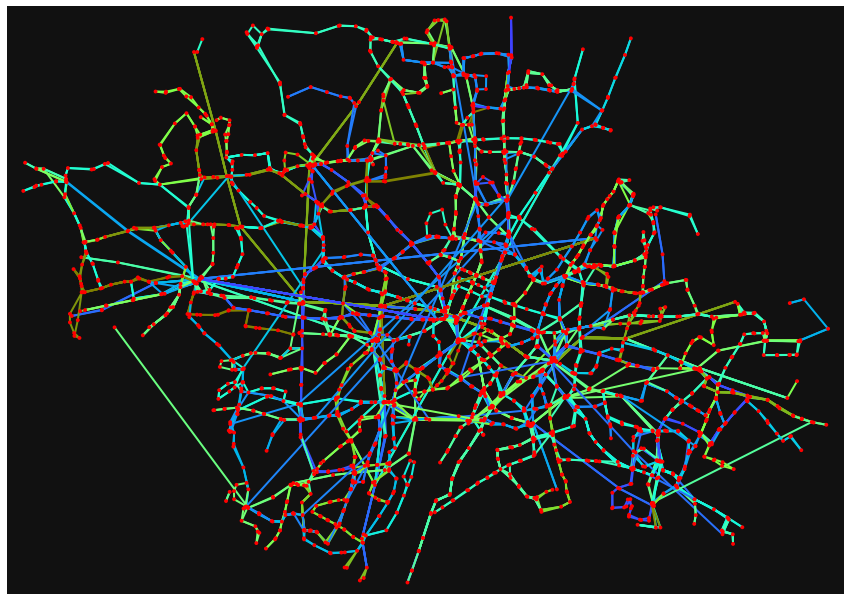

In [53]:
#plot G_public with stopid nodes as red and routes as various colors
from matplotlib import cm
from matplotlib import colors as cmap
import numpy as np
import collections

lineRefList = []
for edge in G_public.edges():
    try:
        lineRefList.append(G_public.edges._adjdict[edge[0]][edge[1]][0]['route'])
    except Exception:
        pass
    
lineRefList = list(set(lineRefList)) #remove duplicate
evenly_spaced_interval = np.linspace(0, 1, len(lineRefList))
colors = [cm.rainbow(x) for x in evenly_spaced_interval]
lineRefDict = {}

for i in range(0, len(colors)):
    r = float(colors[i][0])
    g = float(colors[i][1])
    b = float(colors[i][2])
    nr = r - r/2.0
    ng = g + r/2.0
    if ng > 1.0:
        ng = 1.0
    colors[i] = (nr, ng, b, 1.0)
    lineRefDict[lineRefList[i]] = (cmap.rgb2hex(colors[i]), colors[i][0])

nc = ['r' if('color' in G_public.nodes[node].keys()) else 'w' for node in G_public.nodes()]
nodeList = list(G_public.nodes())
for edge in G_public.edges():
    rgb = lineRefDict[G_public.edges._adjdict[edge[0]][edge[1]][0]['route']][0] #rgb string hex
    if nc[nodeList.index(edge[0])] != 'r':
        nc[nodeList.index(edge[0])] = rgb
    if nc[nodeList.index(edge[1])] != 'r':
        nc[nodeList.index(edge[1])] = rgb

ec = [lineRefDict[G_public.edges._adjdict[edge[0]][edge[1]][0]['route']][0] for edge in G_public.edges()]
el = [lineRefDict[G_public.edges._adjdict[edge[0]][edge[1]][0]['route']][1] for edge in G_public.edges()]
fig, ax = ox.plot_graph(G_public, node_color=nc, edge_color=ec, edge_linewidth=2, figsize=(15,12))


In [70]:
# from matplotlib.animation import FuncAnimation
# from IPython.display import HTML
# # Project graph to 3395 to make CRS coherent with the rest of the objects
# projected_graph_public = ox.project_graph(G_public, to_crs="EPSG:3395")

In [ ]:
# fig, ax = ox.plot_graph(projected_graph_public, node_color=nc, edge_color=ec, edge_linewidth=1, figsize=(15,12))

# def animate(i):
#     clear_output(wait=True)
#     print('Frame: %d' % i)
#     for edge in projected_graph_public.edges():
#         yval = (projected_graph_public.nodes[edge[0]]['y']+np.random.uniform(0,3000))
# #         print(yval)
#         ax.annotate(projected_graph_public.edges._adjdict[edge[0]][edge[1]][0]['route'], (projected_graph_public.nodes[edge[0]]['x'], yval), color='c', weight='bold', fontsize=10)

# # Make the animation
# animation = FuncAnimation(fig, animate, frames=1)   

# # to display animation in Jupyter Notebook
# HTML(animation.to_jshtml())